In [25]:
import os, sys

import pandas as pd
import geopandas as gpd
import contextily as cx
from shapely.geometry import Point

import numpy as np
import math
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
import matplotlib.dates as mdates

from tqdm.notebook import tqdm as tqdm_notebook


from owslib.ogcapi.features import Features
from rich.console import Console

from calendar import isleap
from scipy import linalg


sys.path.append(r'C:\EODC\Kundenprojekte\INTERFACE\INTERFACE_lib')
import INTERFACE_lib as interface


%matplotlib inline
#%matplotlib widget

## Define some functions

### Returns the number of days in a year (365 or 366 if it is a leap year)

In [19]:
def days_of_year(year):
    return 366 if isleap(year) else 365

### Calculate the number of days between the two dates

In [20]:
def annual_difference(start, end):

    total_days = (end - start).days
    
    # Calculate the annual difference based on the days and the different years
    yearly_share = 0.0
    
    # First part: share of start year
    days_start_year = days_of_year(start.year)
    remaining_days_start = days_start_year - (start - datetime(start.year, 1, 1)).days
    days_until_end = min(total_days, remaining_days_start)
    yearly_share += days_until_end / days_start_year
    
    total_days -= days_until_end
    current_year = start.year + 1
    
    # Part two: full years in between
    while total_days > 0 and current_year < end.year:
        days_current_year = days_of_year(current_year)
        days_until_end = min(total_days, days_current_year)
        yearly_share += days_until_end / days_current_year
        total_days -= days_until_end
        current_year += 1
    
    # Third part: share of final year
    if total_days > 0:
        days_end_year = days_of_year(end.year)
        yearly_share += total_days / days_end_year
    
    return yearly_share

### Returns EGMS time series parameter: RMSE, EstimatedVelocity, EstimatedSTD_Vel, EstimatedAcceleration, EstimatedSTD_Acc, EstimatedSeasonAMP, EstimatedSTD_SeasonAMP

In [21]:
def timeseries_parameter (ts_date_num, ts_data):
    
    dtime = np.zeros(len(ts_date_num))

    for i,d in enumerate (ts_date_num):
        dtime[i] = annual_difference(ts_date_num[0], d)

    # Task 1 - Computation of the RMSE of each Time Series and estimation of the Amplitude of the Seasonal Component

    G = np.array([dtime**3, dtime**2, dtime, np.ones(len(dtime)), np.cos(2*np.pi*dtime), np.sin(2*np.pi*dtime)])
    G = G.T
    # inversion 
    invG = linalg.pinv(G.T@G) # pseudoinverse(Moore-Penrose) 
    Coeff = invG@G.T@ts_data
    x1_model = G@Coeff
    
    # Compute RMSE

    RMSE = np.sqrt( np.mean( (ts_data-x1_model)**2 ) ) # [mm]

    # Compute the amplitude of the seasonal component and its StDev

    EstimatedSeasonAMP = np.sqrt( Coeff[4]**2+Coeff[5]**2 )
    EstimatedSTD_SeasonAMP = np.sqrt( (4-np.pi)/2*(invG[4,4]+invG[5,5])/2 )*RMSE  # in [mm]
    # In fact, this is the StDev of a Rayleigh distribution, since the amp of the seasonal component is sqrt( COEFF(5).^2+COEFF(6).^2 ); and we suppose a gaussian statistics

    # Task 2 - Compute Mean Velocity and its StdDev

    G = np.array([dtime, np.ones(len(dtime)), np.cos(2*np.pi*dtime), np.sin(2*np.pi*dtime)])
    G = G.T
    # inversion 
    invG = linalg.pinv(G.T@G) # pseudoinverse(Moore-Penrose) 
    Coeff2 = invG@G.T@ts_data
    x1_model2 = G@Coeff2

    EstimatedVelocity = Coeff2[0] # [mm/yr] 
    RMSE_Velocity = np.std(ts_data-x1_model2)
    EstimatedSTD_Vel = np.sqrt(invG[0,0])*RMSE_Velocity # in [mm/yr]

    # Task 3 - Compute Acceleration and its StdDev

    G = np.array([0.5*dtime**2, dtime, np.ones(len(dtime)), np.cos(2*np.pi*dtime), np.sin(2*np.pi*dtime)])
    G = G.T
    # inversion 
    invG = linalg.pinv(G.T@G) # pseudoinverse(Moore-Penrose) 
    Coeff3 = invG@G.T@ts_data
    x1_model3 = G@Coeff3

    EstimatedAcceleration = Coeff3[0] # [mm/yr] 
    RMSE_Acceleration = np.std(ts_data-x1_model3)
    EstimatedSTD_Acc = np.sqrt(invG[0,0])*RMSE_Acceleration # in [mm/yr]

    return RMSE, EstimatedVelocity, EstimatedSTD_Vel, EstimatedAcceleration, EstimatedSTD_Acc, EstimatedSeasonAMP, EstimatedSTD_SeasonAMP, RMSE_Velocity, RMSE_Acceleration

## Connect to the EODC Feature Service

In [2]:
console = Console()

EODC_OGCAPI_URL = 'https://features.services.eodc.eu/'
eodc_ogcapi = Features(EODC_OGCAPI_URL)

#collections = eodc_ogcapi.collections()
#console.print(collections)

feature_collections = eodc_ogcapi.feature_collections()
console.print(feature_collections)

[
    'adriatic_vessels',
    'Vlbg_EGMS_L3_E',
    'Vlbg_EGMS_L3_U',
    'STATISTIK_AUSTRIA_DSR',
    'pub_yipeeo_yield_fl',
    'pub_yipeeo_yield_nuts2',
    'prv_yipeeo_yield_field',
    'prv_yipeeo_yield_nuts1',
    'prv_yipeeo_yield_nuts2',
    'prv_yipeeo_yield_nuts3',
    'prv_yipeeo_yield_nuts4',
    'prv_yipeeo_fertilize',
    'prv_yipeeo_irrigate',
    'world_administrative_boundaries'
]

### Set the Area of interest search for matching items in the collection

In [3]:
bbox = [9.730522,47.529589,9.769661,47.561321]

field_items = eodc_ogcapi.collection_items(
    "Vlbg_EGMS_L3_U",
    bbox = bbox,
    limit = 2000,
)
console.print(f"We found {len(field_items['features'])} items matching the query criteria.")

df = gpd.GeoDataFrame.from_features(field_items["features"], crs="EPSG:4326")

We found 548 items matching the query criteria.

In [15]:
df_sorted = df[sorted(df.columns)]
df_sorted.head(3)

,20160105,20160111,20160117,20160123,20160129,20160204,20160210,20160216,20160222,20160228,...,geometry,height,layer,mean_vel_1,mean_veloc,northing,path,rmse,seasonal_1,seasonalit
0,0.1,-0.9,-1.6,-2.4,-2.7,-2.1,-0.5,0.7,0.8,1.0,...,POINT (9.73655 47.53255),387.7,Zusammengefasster Layer,0.1,-1.8,2713250,"PointZ?crs=EPSG:3035&field=pid:string(0,0)&fie...",2.2,0.1,1.3
1,1.0,0.3,-1.0,-1.4,-0.4,0.7,1.8,2.7,2.7,2.1,...,POINT (9.73788 47.53255),392.1,Zusammengefasster Layer,0.0,-4.0,2713250,"PointZ?crs=EPSG:3035&field=pid:string(0,0)&fie...",1.1,0.1,1.6
2,-0.1,-0.1,0.3,0.3,0.4,0.9,0.9,0.5,0.1,-0.0,...,POINT (9.73921 47.53255),396.3,Zusammengefasster Layer,0.0,-3.5,2713250,"PointZ?crs=EPSG:3035&field=pid:string(0,0)&fie...",0.9,0.0,1.3


### Plot the points

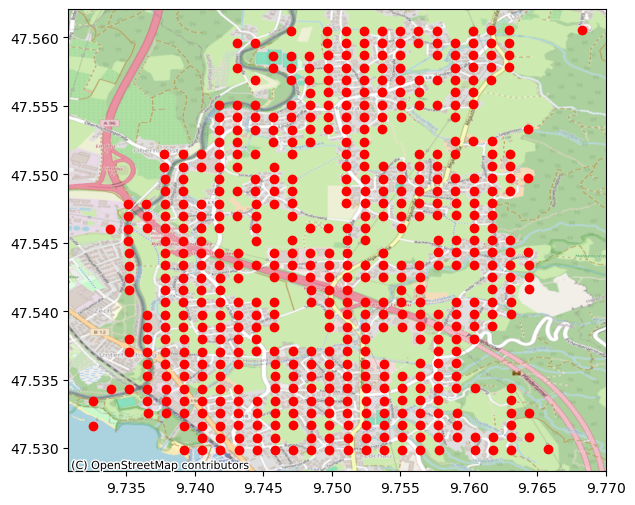

In [5]:
ax = df_sorted[["geometry"]].plot(
    facecolor="red", figsize=(12, 6)
)
cx.add_basemap(ax, crs=df.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik);

## Format the dataframe

In [16]:
ts_np = df_sorted.to_numpy()
columns_names=list(df_sorted)
df_len = columns_names.index('AREA_')
acquisition_dates = columns_names[0:df_len]
#print(acquisition_dates)

acquisition_date_str = [f"{d[:4]}-{d[4:6]}-{d[6:8]}" for d in acquisition_dates]
acquisition_date_num = [datetime.strptime(d, "%Y-%m-%d") for d in acquisition_date_str]

### Plot the time series of all points

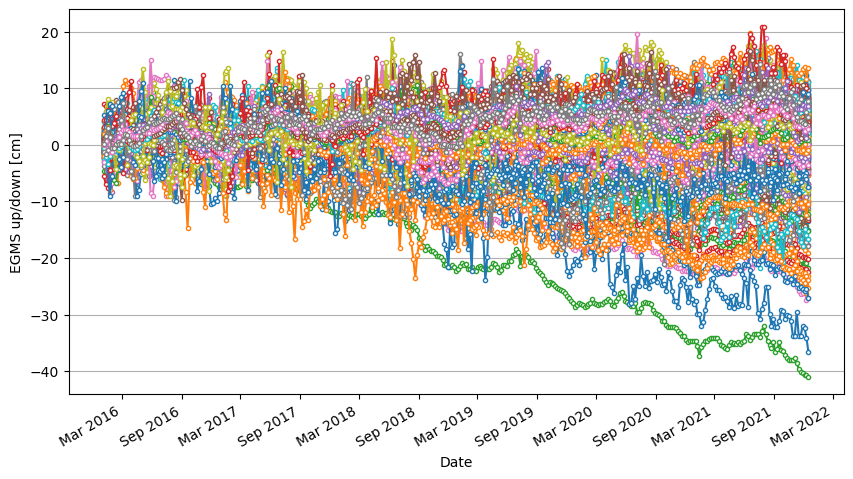

In [7]:
fig_EGMS_timeseries, axes = plt.subplots(nrows=1, ncols=1,facecolor='white', figsize=[10, 5])

for i in range(len(ts_np)):
    axes.plot(acquisition_date_num,ts_np[i,0:df_len], ".-", markerfacecolor="w")

axes.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
axes.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(axes.get_xticklabels(), rotation=30, ha="right")
axes.set_xlabel('Date')
axes.set_ylabel('EGMS up/down [cm]')
axes.grid(visible=True,axis='y')

## Calculate new Values

### Initialize two NumPy arrays with the length of the number of rows in ts_np

In [8]:
RMSE_Velocity = np.empty(ts_np.shape[0])
RMSE_Acceleration = np.empty(ts_np.shape[0])

### Calculate the parameters RMSE, EstimatedVelocity, EstimatedSTD_Vel, EstimatedAcceleration, EstimatedSTD_Acc, EstimatedSeasonAMP, EstimatedSTD_SeasonAMP in a loop over the time series

In [27]:
for i in tqdm_notebook (range(ts_np.shape[0])):

    _, _, _, _, _, _, _, RMSE_Velocity[i], RMSE_Acceleration[i] = timeseries_parameter(acquisition_date_num, ts_np[i, :df_len])

  0%|          | 0/548 [00:00<?, ?it/s]

### Calculate the significance of velocity, acceleration and seasonality

In [47]:
mean_velocity = df_sorted.mean_veloc
mean_velocity_std = df_sorted.mean_vel_1

Significance_Velocity = np.abs(mean_velocity.values) > 3*mean_velocity_std.values

acceleration = df_sorted.accelerati
acceleration_std = df_sorted.accelera_1

Significance_Acceleration = np.abs(acceleration.values) > 3*acceleration_std.values

seasonality = df_sorted.seasonalit
seasonality_std = df_sorted.seasonal_1

Significance_Seasonality = np.abs(seasonality.values) > 3*seasonality_std.values

### Add columns to the egms dataframe with the informations calculated

In [48]:
df_sorted.loc[:, 'RMSE_Velocity'] = pd.Series(RMSE_Velocity, index=df_sorted.index)
df_sorted.loc[:, 'RMSE_Acceleration'] = pd.Series(RMSE_Acceleration, index=df_sorted.index)
df_sorted.loc[:, 'Significance_Velocity'] = pd.Series(Significance_Velocity, index=df_sorted.index)
df_sorted.loc[:, 'Significance_Acceleration'] = pd.Series(Significance_Acceleration, index=df_sorted.index)
df_sorted.loc[:, 'Significance_Seasonality'] = pd.Series(Significance_Seasonality, index=df_sorted.index)
df_sorted.loc[:, 'name'] = pd.Series(df_sorted.index, index=df_sorted.index)

In [49]:
df_sorted.head(3)

,20160105,20160111,20160117,20160123,20160129,20160204,20160210,20160216,20160222,20160228,...,seasonalit,RMSE_Velocity,RMSE_Acceleration,Significance_Velocity,Significance_Acceleration,Significance_Seasonality,name,use_mean_velocity,nonzero_mean_velocity,nonzero_acceleration
0,0.1,-0.9,-1.6,-2.4,-2.7,-2.1,-0.5,0.7,0.8,1.0,...,1.3,2.384912,2.262593,True,True,True,0,False,False,False
1,1.0,0.3,-1.0,-1.4,-0.4,0.7,1.8,2.7,2.7,2.1,...,1.6,1.124824,1.123803,True,False,True,1,False,False,False
2,-0.1,-0.1,0.3,0.3,0.4,0.9,0.9,0.5,0.1,-0.0,...,1.3,0.938989,0.931850,True,False,True,2,False,False,False


### Plot all new calculated values

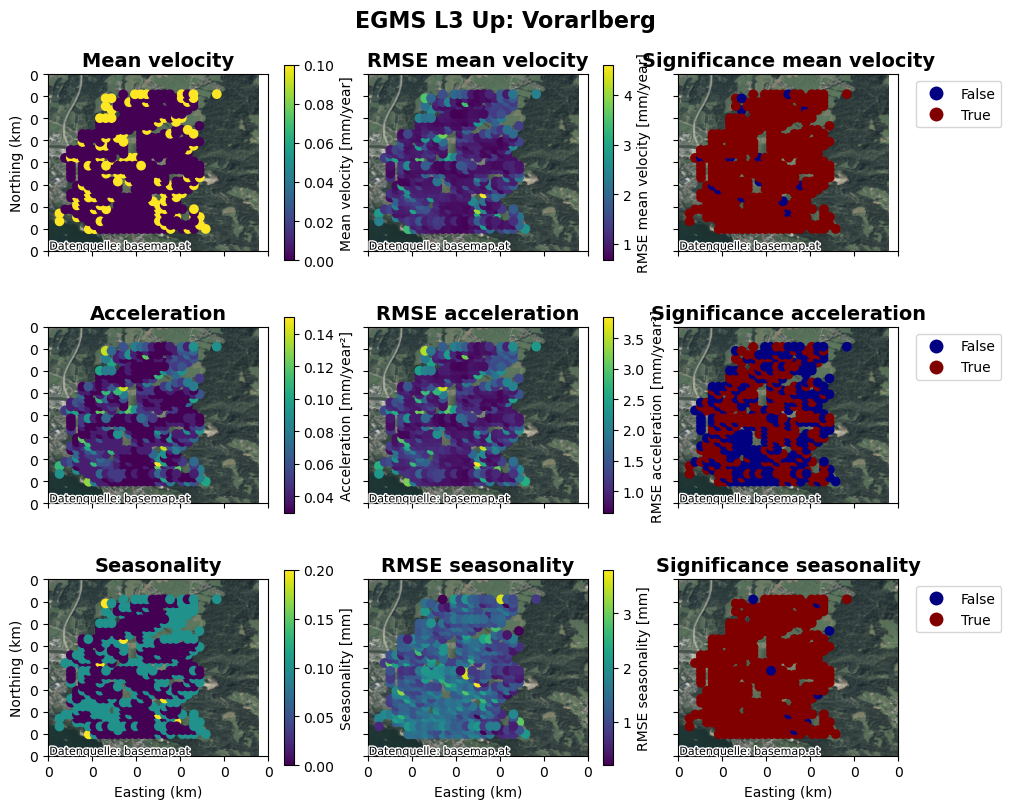

In [50]:
dShrink = 0.8

fig, axs = plt.subplots(3, 3, figsize=(10, 8), sharex=True, sharey=True, layout='constrained')

# hier column-name austauschen 
ax = df_sorted.plot(ax=axs[0,0],column='mean_vel_1', legend=True, legend_kwds={"label": "Mean velocity [mm/year]", "shrink":dShrink})
yticks = axs[0,0].get_yticks()
axs[0,0].set_yticks (yticks)
axs[0,0].set_yticklabels([int(y / 1000) for y in yticks])
axs[0,0].set_ylabel('Northing (km)')

cx.add_basemap(axs[0, 0], crs=df_sorted.crs.to_string(), source=cx.providers.BasemapAT.orthofoto);
ax.set_title('Mean velocity', fontsize=14, fontweight='bold', loc='center')

ax = df_sorted.plot(ax=axs[0,1],column='RMSE_Velocity', legend=True, legend_kwds={"label": "RMSE mean velocity [mm/year]", "shrink":dShrink})
cx.add_basemap(axs[0, 1], crs=df_sorted.crs.to_string(), source=cx.providers.BasemapAT.orthofoto);
ax.set_title('RMSE mean velocity', fontsize=14, fontweight='bold', loc='center')

ax = df_sorted.plot(ax=axs[0,2],column='Significance_Velocity', legend=True , cmap='jet', legend_kwds={'loc':'upper left', 'bbox_to_anchor':(1.05, 1)})
cx.add_basemap(axs[0, 2], crs=df_sorted.crs.to_string(), source=cx.providers.BasemapAT.orthofoto);
ax.set_title('Significance mean velocity', fontsize=14, fontweight='bold', loc='center')

# hier column-name austauschen
ax = df_sorted.plot(ax=axs[1,0],column='accelera_1', legend=True, legend_kwds={"label": "Acceleration [mm/year²]", "shrink":dShrink})
cx.add_basemap(axs[1, 0], crs=df_sorted.crs.to_string(), source=cx.providers.BasemapAT.orthofoto);
ax.set_title('Acceleration', fontsize=14, fontweight='bold', loc='center')

ax = df_sorted.plot(ax=axs[1,1],column='RMSE_Acceleration', legend=True, legend_kwds={"label": "RMSE acceleration [mm/year²]", "shrink":dShrink})
cx.add_basemap(axs[1, 1], crs=df_sorted.crs.to_string(), source=cx.providers.BasemapAT.orthofoto);
ax.set_title('RMSE acceleration', fontsize=14, fontweight='bold', loc='center')
#axs[1,1].set_xlabel('Easting (km)')

ax = df_sorted.plot(ax=axs[1,2],column='Significance_Acceleration', legend=True , cmap='jet', legend_kwds={'loc':'upper left', 'bbox_to_anchor':(1.05, 1)})
cx.add_basemap(axs[1, 2], crs=df_sorted.crs.to_string(), source=cx.providers.BasemapAT.orthofoto);
ax.set_title('Significance acceleration', fontsize=14, fontweight='bold', loc='center')
#axs[1,2].set_xlabel('Easting (km)')

# hier column-name austauschen
ax = df_sorted.plot(ax=axs[2,0],column='seasonal_1', legend=True, legend_kwds={"label": "Seasonality [mm]", "shrink":dShrink})
cx.add_basemap(axs[2, 0], crs=df_sorted.crs.to_string(), source=cx.providers.BasemapAT.orthofoto);
ax.set_title('Seasonality', fontsize=14, fontweight='bold', loc='center')

axs[2,0].set_ylabel('Northing (km)')
xticks = axs[2,0].get_xticks()
axs[2,0].set_xticks (xticks)
axs[2,0].set_xticklabels([int(x / 1000) for x in xticks])
axs[2,0].set_xlabel('Easting (km)')

# hier column-name austauschen
ax = df_sorted.plot(ax=axs[2,1],column='seasonalit', legend=True, legend_kwds={"label": "RMSE seasonality [mm]", "shrink":dShrink})
cx.add_basemap(axs[2, 1], crs=df_sorted.crs.to_string(), source=cx.providers.BasemapAT.orthofoto);
ax.set_title('RMSE seasonality', fontsize=14, fontweight='bold', loc='center')
axs[2,1].set_xlabel('Easting (km)')

ax = df_sorted.plot(ax=axs[2,2],column='Significance_Seasonality', legend=True, cmap='jet', legend_kwds={'loc':'upper left', 'bbox_to_anchor':(1.05, 1)})
cx.add_basemap(axs[2, 2], crs=df_sorted.crs.to_string(), source=cx.providers.BasemapAT.orthofoto);
ax.set_title('Significance seasonality', fontsize=14, fontweight='bold', loc='center')
axs[2,2].set_xlabel('Easting (km)')

fig.suptitle('EGMS L3 Up', fontsize=16, fontweight='bold')

plt.show()

#if (lSaveFig):
#    fig.savefig( os.path.join( out_path,'EGMS_test.png'), format='png')

## Identify points with possible landslides

### Check which deformation regime (mean velocity or accelerartion) is more realistic

In [51]:
#True if RSME_Velocity < RSME_Acceleration -> then use the RSME_Velocity
use_mean_velocity = df_sorted.RMSE_Velocity.values < df_sorted.RMSE_Acceleration.values

#set a threshold for mean_velocity and acceleration
mean_velocity_threshold = 2 # [mm/year]
acceleration_threshold = 0.5 # [mm/year²]

#Check if mean_velocity and acceleration are bigger than the treshold
nonzero_mean_velocity = np.abs(mean_velocity.values) > mean_velocity_threshold
nonzero_acceleration = np.abs(acceleration.values) > acceleration_threshold

#Add them to the dataframe
df_sorted.loc[:, 'use_mean_velocity'] = pd.Series(use_mean_velocity, index=df_sorted.index)
df_sorted.loc[:, 'nonzero_mean_velocity'] = pd.Series(nonzero_mean_velocity, index=df_sorted.index)
df_sorted.loc[:, 'nonzero_acceleration'] = pd.Series(nonzero_acceleration, index=df_sorted.index)


### Plot use_mean_velocity, nonzero_mean_velocity and nonzero_acceleration

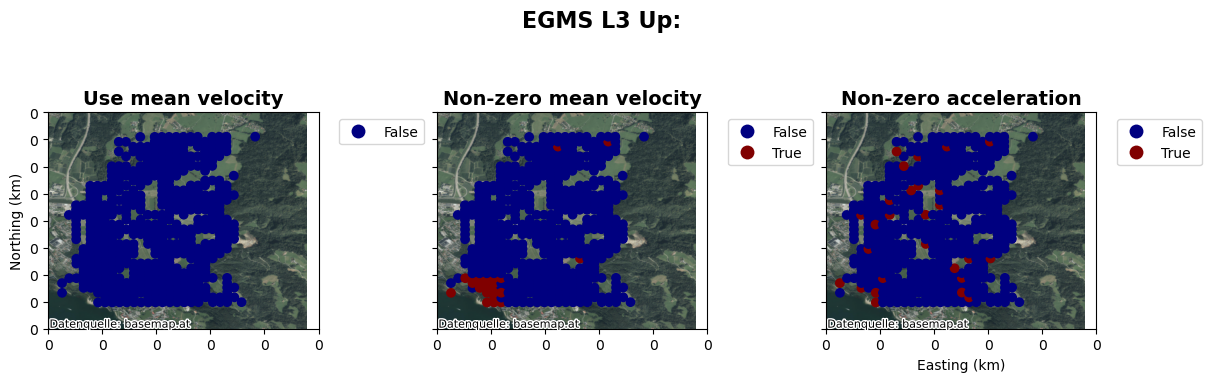

In [54]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), layout='constrained', sharex=True, sharey=True)

ax = df_sorted.plot(ax=axs[0],column='use_mean_velocity', legend=True, cmap='jet', legend_kwds={'loc':'upper left', 'bbox_to_anchor':(1.05, 1)})
yticks = axs[0].get_yticks()
axs[0].set_yticks (yticks)
axs[0].set_yticklabels([int(y / 1000) for y in yticks])
axs[0].set_ylabel('Northing (km)')

cx.add_basemap(axs[0], crs=df_sorted.crs.to_string(), source=cx.providers.BasemapAT.orthofoto);
ax.set_title('Use mean velocity', fontsize=14, fontweight='bold', loc='center')

ax = df_sorted.plot(ax=axs[1],column='nonzero_mean_velocity', legend=True, cmap='jet', legend_kwds={'loc':'upper left', 'bbox_to_anchor':(1.05, 1)})
cx.add_basemap(axs[1], crs=df_sorted.crs.to_string(), source=cx.providers.BasemapAT.orthofoto);
ax.set_title('Non-zero mean velocity', fontsize=14, fontweight='bold', loc='center')

ax = df_sorted.plot(ax=axs[2],column='nonzero_acceleration', legend=True, cmap='jet', legend_kwds={'loc':'upper left', 'bbox_to_anchor':(1.05, 1)})
cx.add_basemap(axs[2], crs=df_sorted.crs.to_string(), source=cx.providers.BasemapAT.orthofoto);
ax.set_title('Non-zero acceleration', fontsize=14, fontweight='bold', loc='center')

xticks = axs[2].get_xticks()
axs[2].set_xticks (xticks)
axs[2].set_xticklabels([int(x / 1000) for x in xticks])
axs[2].set_xlabel('Easting (km)')

fig.suptitle('EGMS L3 Up', fontsize=16, fontweight='bold')

plt.show()

In [126]:
points_to_check = nonzero_mean_velocity | nonzero_acceleration # numpy or

cgdf = df_sorted[points_to_check]

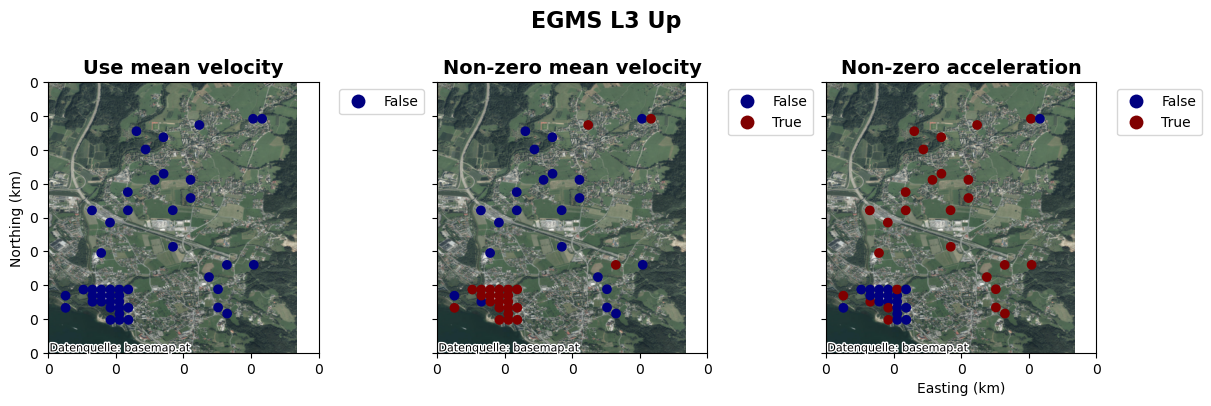

In [127]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), layout='constrained', sharex=True, sharey=True)

ax = cgdf.plot(ax=axs[0],column='use_mean_velocity', legend=True, cmap='jet', legend_kwds={'loc':'upper left', 'bbox_to_anchor':(1.05, 1)})
yticks = axs[0].get_yticks()
axs[0].set_yticks (yticks)
axs[0].set_yticklabels([int(y / 1000) for y in yticks])
axs[0].set_ylabel('Northing (km)')

cx.add_basemap(axs[0], crs=cgdf.crs.to_string(), source=cx.providers.BasemapAT.orthofoto);
ax.set_title('Use mean velocity', fontsize=14, fontweight='bold', loc='center')

ax = cgdf.plot(ax=axs[1],column='nonzero_mean_velocity', legend=True, cmap='jet', legend_kwds={'loc':'upper left', 'bbox_to_anchor':(1.05, 1)})
cx.add_basemap(axs[1], crs=cgdf.crs.to_string(), source=cx.providers.BasemapAT.orthofoto);
ax.set_title('Non-zero mean velocity', fontsize=14, fontweight='bold', loc='center')

ax = cgdf.plot(ax=axs[2],column='nonzero_acceleration', legend=True, cmap='jet', legend_kwds={'loc':'upper left', 'bbox_to_anchor':(1.05, 1)})
cx.add_basemap(axs[2], crs=cgdf.crs.to_string(), source=cx.providers.BasemapAT.orthofoto);
ax.set_title('Non-zero acceleration', fontsize=14, fontweight='bold', loc='center')

xticks = axs[2].get_xticks()
axs[2].set_xticks (xticks)
axs[2].set_xticklabels([int(x / 1000) for x in xticks])
axs[2].set_xlabel('Easting (km)')

fig.suptitle('EGMS L3 Up', fontsize=16, fontweight='bold')

plt.show()

### Plot all points with possible landslides on a map
Combination of use_mean_velocity and nonzero_mean_velocity/nonzero_acceleration

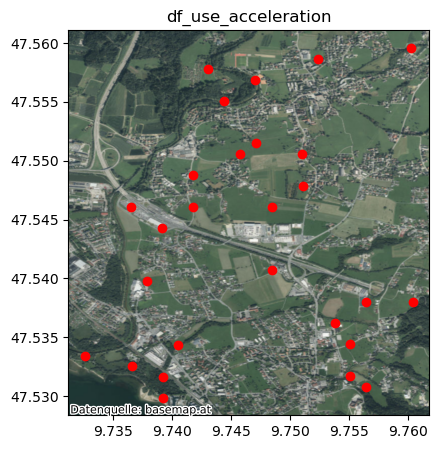

In [119]:
df_use_mean_velocity = df_sorted[(df_sorted['use_mean_velocity'] == True) & (df_sorted['nonzero_mean_velocity'] == True)]
df_use_acceleration = df_sorted[(df_sorted['use_mean_velocity'] == False) & (df_sorted['nonzero_acceleration'] == True)]


if df_use_mean_velocity.empty == True and df_use_acceleration.empty == True:
    print("Both dataframes are empty")
elif df_use_mean_velocity.empty == True and df_use_acceleration.empty == False:
    fig, ax = plt.subplots(figsize = (5,5))
    df_use_acceleration.plot(ax=ax, color='red')
    cx.add_basemap(ax, crs=df_sorted.crs.to_string(), source=cx.providers.BasemapAT.orthofoto)
    ax.set_title('df_use_acceleration')
    plt.show()
elif df_use_mean_velocity.empty == False and df_use_acceleration.empty == True:
    fig, ax = plt.subplots(figsize = (5,5))
    df_use_mean_velocity.plot(ax=ax, color='red')
    cx.add_basemap(ax, crs=df_sorted.crs.to_string(), source=cx.providers.BasemapAT.orthofoto)
    ax.set_title('df_use_mean_velocity')
    plt.show()
else:
    fig, axs = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
    
    # Plot for df_use_acceleration
    df_use_acceleration.plot(ax=axs[0], color='red')
    cx.add_basemap(axs[0], crs=df_sorted.crs.to_string(), source=cx.providers.BasemapAT.orthofoto)
    axs[0].set_title('df_use_acceleration')
    
    # Plot for df_use_mean_velocity
    df_use_mean_velocity.plot(ax=axs[1], color='red')
    cx.add_basemap(axs[1], crs=df_sorted.crs.to_string(), source=cx.providers.BasemapAT.orthofoto)
    axs[1].set_title('df_use_mean_velocity')
    
    plt.show()

### Plot all points with possible landslides in a diagram

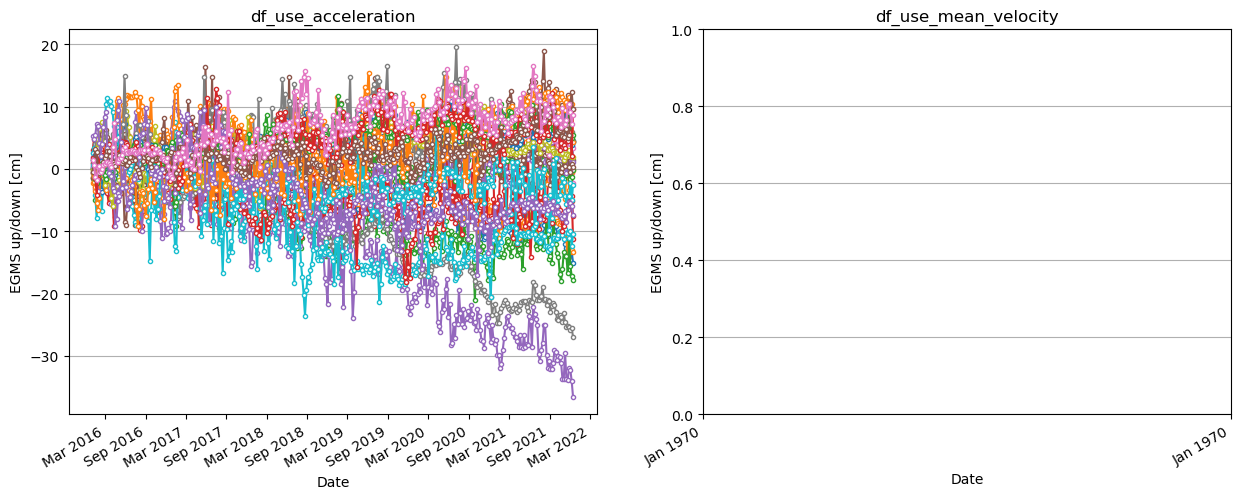

In [121]:
fig, axs = plt.subplots(nrows=1, ncols=2, facecolor='white', figsize=[15, 5])

# Plot for df_use_acceleration
for i in range(len(df_use_acceleration)):
    axs[0].plot(acquisition_date_num, df_use_acceleration.iloc[i, 0:df_len], ".-", markerfacecolor="w")

axs[0].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
axs[0].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(axs[0].get_xticklabels(), rotation=30, ha="right")
axs[0].set_xlabel('Date')
axs[0].set_ylabel('EGMS up/down [cm]')
axs[0].grid(visible=True, axis='y')
axs[0].set_title('df_use_acceleration')

# Plot for df_use_mean_velocity
for i in range(len(df_use_mean_velocity)):
    axs[1].plot(acquisition_date_num, df_use_mean_velocity.iloc[i, 0:df_len], ".-", markerfacecolor="w")

axs[1].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(axs[1].get_xticklabels(), rotation=30, ha="right")
axs[1].set_xlabel('Date')
axs[1].set_ylabel('EGMS up/down [cm]')
axs[1].grid(visible=True, axis='y')
axs[1].set_title('df_use_mean_velocity')

plt.show()


## TBD: on click events??

In [ ]:
def plot_timeseries(gdf, pid, dmin, dmax, lSaveFig, sFigName):

    v1_sorted = gdf[sorted(gdf.columns)]
    columns_names=list(v1_sorted)
    v1_len = min(columns_names.index('acceleration'), columns_names.index('RMSE_Acceleration'))
    acquisition_dates = columns_names[0:v1_len]
    v1_acquisition_date_str = [f"{d[:4]}-{d[4:6]}-{d[6:8]}" for d in acquisition_dates]
    ts_date_num = [datetime.strptime(d, "%Y-%m-%d") for d in v1_acquisition_date_str]
    ts_data = v1_sorted.to_numpy()

    i = gdf.loc[gdf['pid'] == pid].index[0]
    x1 = ts_data [i,:v1_len]

    fig_EGMS_timeseries, axes = plt.subplots(nrows=1, ncols=1,facecolor='white', figsize=[10, 5],layout='constrained')

    axes.plot(ts_date_num,x1, ".", markerfacecolor="w", label = 'EGMS up/down')

    axes.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    axes.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    plt.setp(axes.get_xticklabels(), rotation=30, ha="right")
    axes.set_xlabel('Date')
    axes.set_ylabel('Deformation [mm]')
    axes.grid(visible=True,axis='y')

    axes.set_xlim(ts_date_num[0], ts_date_num[-1])
    axes.set_ylim(dmin, dmax)

    plt.legend(fontsize = 10, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    axes.set_title("PID: " + check_pid)
    plt.show()

    if (lSaveFig):
        fig_EGMS_timeseries.savefig(sFigName, format='png')

    #plt.close()

In [ ]:
EGMS_name = r"D:\06_Work\2022_INTERFACE\Product_Ground_Motion_Service\AT_EGMS_L3_U_2016_2021.gpkg"
out_path = r"D:\06_Work\2022_INTERFACE"

sTestsite = 'Vorarlberg'
check_pid1 = '20WzAMphEy'  # Wolfurt - Doppelmayr ... linear
check_pid2 = '20X2s5Qhl2'  # Rheinmündung ... accelerated
check_pid3 = '20WzXo9vD1'  # Wolfurt - Bahnhof ... seasonal

sTestsite = 'Eisenstadt'

check_pid1 = '10Xm5bFHSi'  #  ... linear
check_pid2 = '10XlwDun4e'  #  ... accelerated
check_pid3 = '10Xm0ua2Gd'  #  ... seasonal

AOI_name = r'D:\06_Work\2022_INTERFACE\EGMS_Test_Area_' + sTestsite +'.gpkg'
EGMS_clipped_name = r'D:\06_Work\2022_INTERFACE\AT_EGMS_L3_U_2016_2021_' + sTestsite +'.gpkg'
EGMS_stats_clipped_name = r'D:\06_Work\2022_INTERFACE\AT_EGMS_L3_U_2016_2021_' + sTestsite + '_stats.gpkg'

lSaveFig = False
lSaveFig = True

In [ ]:
columns=["pid","easting","northing","height","rmse","mean_velocity","mean_velocity_std","acceleration","acceleration_std","seasonality","seasonality_std", \
          "RMSE_Velocity","RMSE_Acceleration","Significance_Velocity","Significance_Acceleration","Significance_Seasonality","name"]

odf = pd.DataFrame(egms_gdf, columns=columns)

ogdf = gpd.GeoDataFrame( odf, geometry=gpd.points_from_xy(odf.easting, odf.northing), crs="EPSG:3035" )

ogdf.to_file(EGMS_stats_clipped_name, layer='Up-Down-Component_Stats', driver="GPKG")

In [ ]:
centroid = ogdf.geometry.union_all().centroid

trans = Transformer.from_crs(ogdf.crs, "EPSG:4326",always_xy=True,)
xx, yy = trans.transform(centroid.x, centroid.y)

lShowLegend = False

m = ogdf.explore(location=[yy, xx], width=750, height=500, zoom_start=12.5,
                 column="seasonality",marker_kwds=dict(radius=3, fill=True), categorical=False,
                 popup=['pid','seasonality', 'acceleration', 'mean_velocity'],
                 name='Seasonality [mm]', legend=lShowLegend)

l = ogdf.explore(column='acceleration',marker_kwds=dict(radius=3, fill=True), categorical=False,
                 popup=['pid','seasonality', 'acceleration', 'mean_velocity'],
                 name='Acceleration [mm/y²]', legend=lShowLegend, m=m)

l = ogdf.explore(column='mean_velocity',marker_kwds=dict(radius=3, fill=True), categorical=False,
                 popup=['pid','seasonality', 'acceleration', 'mean_velocity'],  # Popups mit mehreren Spalten
                 name='Mean velocity [mm/y]', legend=lShowLegend, m=m)

folium.TileLayer("BasemapAT.orthofoto", show=False).add_to(m)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control

# JavaScript für das Kopieren in die Zwischenablage und Interaktion
copy_to_clipboard_js = """
{% macro html(this, kwargs) %}
    <script>
        // Funktion zum Kopieren der Werte in die Zwischenablage
        function copyToClipboard(text) {
            const el = document.createElement('textarea');
            el.value = text;
            document.body.appendChild(el);
            el.select();
            document.execCommand('copy');
            document.body.removeChild(el);
            alert('Copied to clipboard: ' + text);
        }

        // Füge ein Event hinzu, wenn auf einen Punkt geklickt wird
        document.getElementsByClassName('leaflet-popup-content')[0]
            .addEventListener('click', function(e) {
                var popupContent = e.target.innerText;
                var pid = popupContent.match(/pid: (\\d+(\\.\\d+)?)/)[0]; // Population extrahieren
                var mean_velocity = popupContent.match(/mean_velocity: (\\d+(\\.\\d+)?)/)[0]; // Area extrahieren
                var clipboardText = pid + '\\n' + mean_velocity;
                copyToClipboard(clipboardText); // Werte in die Zwischenablage kopieren
            });
    </script>
{% endmacro %}
"""

# Füge das JavaScript für das Kopieren in die Zwischenablage als Macro hinzu
clipboard_macro = MacroElement()
clipboard_macro._template = Template(copy_to_clipboard_js)
m.get_root().add_child(clipboard_macro)

m  # show map

if (lSaveFig):
    m.save( os.path.join( out_path,'EGMS_L3_UD_'+sTestsite+'_map.html'))


In [ ]:
check_pid1
10Xm5bFHSi

In [ ]:
sFigName = os.path.join( out_path,'EGMS_L3_UD_'+sTestsite+'_PID_'+check_pid1+'.png')
plot_timeseries(egms_gdf, check_pid1, -60, 20, lSaveFig, sFigName)

sFigName = os.path.join( out_path,'EGMS_L3_UD_'+sTestsite+'_PID_'+check_pid2+'.png')
plot_timeseries(egms_gdf, check_pid2, -60, 20, lSaveFig, sFigName)

sFigName = os.path.join( out_path,'EGMS_L3_UD_'+sTestsite+'_PID_'+check_pid3+'.png')
plot_timeseries(egms_gdf, check_pid3, -60, 20, lSaveFig, sFigName)
